# Figuras Opera

#### Cargamos las librerias y preparamos los datos

In [24]:
library(ggplot2)
library(zoo)
library(forecast)
library(tseries)
library(FitARMA)
library(opera)

datos <- read.csv('monthly-traffic-fatalities-in-on.csv')
accidentes <- ts(datos, start = c(1960, 1), frequency = 12)

acc.train <- window(accidentes, start = c(1960,1), end = c(1973,12))
acc.test <- window(accidentes, start = c(1974,1))

#### Función genérica para plotting de test vs pred a través de ggplot2

In [25]:
combine <- function(test, pred) {
  require(ggplot2)
  p <- ggplot() +
    geom_line(aes(x = index(as.zoo(test)), y = coredata(as.zoo(test)), colour = 'Test')) +
    geom_line(aes(x = index(as.zoo(test)), y = pred, colour = 'Prediccion')) +
    scale_color_manual(name = '', values = c('Test' = 'black', 'Prediccion' = 'red'),
                       labels = c('Test','Predicción')) +
    xlab('Año 1974') + ylab('Número de accidentes de tráfico') +
    scale_x_continuous(breaks = c(), labels = c())
  p
}

#### Figura 34

In [27]:
red <- nnetar(acc.train, repeats = 25, size = 20, decay = 9.5, p = 20, P = 4)
pred.red <- forecast(red, h = 12)
accuracy(pred.red, acc.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.007704909,19.34203,15.19152,-2.901533,11.53298,0.8564789,0.1842071,NA
Test set,-6.003511215,14.84740,13.28567,-5.772871,10.16575,0.7490294,-0.4259276,0.4429346


In [28]:
sarima <- auto.arima(acc.train, test = 'adf')
pred.sarima <- forecast(sarima, h = 12)
accuracy(pred.sarima, acc.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,1.481911,20.89727,16.32299,-2.080903,13.43304,0.9202698,-0.0813211,NA
Test set,-8.013324,18.19253,14.86938,-8.041157,12.04800,0.8383172,-0.2694620,0.4505771


In [29]:
pred.hw <- hw(acc.train, h = 12, damped = TRUE, seasonal = 'multiplicative',
              initial = 'optimal')
accuracy(pred.hw, acc.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,1.113903,16.03383,12.68223,-0.4267724,9.854084,0.7150085,0.08131717,NA
Test set,-13.063209,20.12153,15.04762,-10.5419375,11.866680,0.8483659,-0.33286407,0.5553684


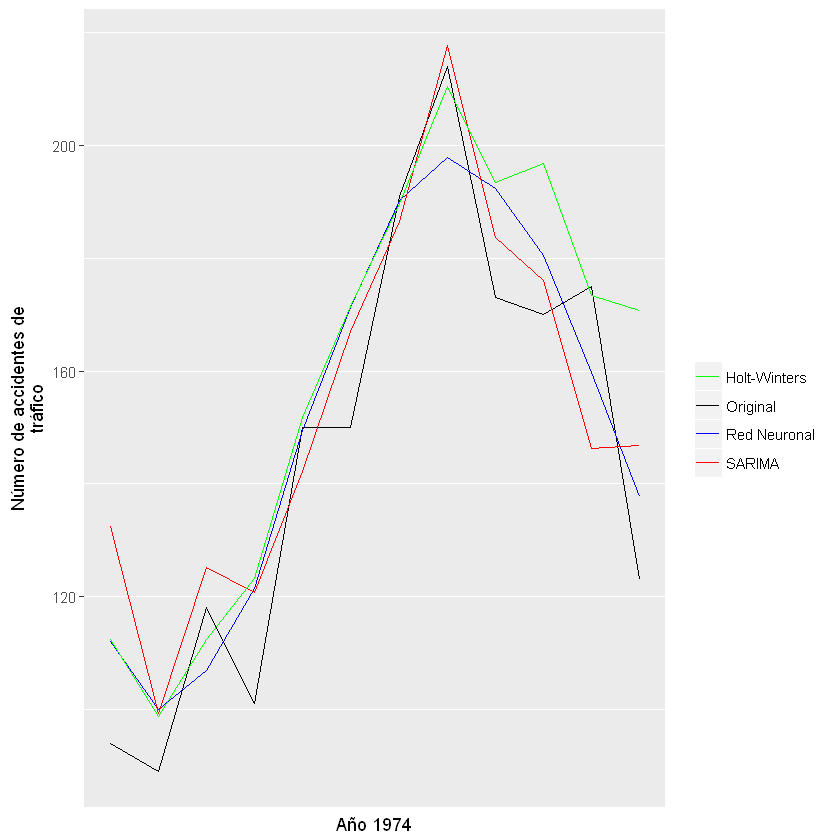

In [30]:
X <- cbind(red = pred.red$mean, sarima = pred.sarima$mean, hw = pred.hw$mean)
p <- ggplot() +
  geom_line(aes(x = index(as.zoo(acc.test)), y = coredata(as.zoo(acc.test)), colour = 'Original')) +
  geom_line(aes(x = index(as.zoo(acc.test)), y = X[, 1], colour = 'Red Neuronal')) +
  geom_line(aes(x = index(as.zoo(acc.test)), y = X[, 2], colour = 'SARIMA')) +
  geom_line(aes(x = index(as.zoo(acc.test)), y = X[, 3], colour = 'Holt-Winters')) +
  scale_color_manual(name = '', values = c('Original' = 'black',
                                                  'Red Neuronal' = 'blue',
                                                  'SARIMA' = 'red',
                                                  'Holt-Winters' = 'green'),
                     labels = c('Holt-Winters','Original', 'Red Neuronal', 'SARIMA')) +
  xlab('Año 1974') + ylab('Número de accidentes de\ntráfico') +
  scale_x_continuous(breaks = c(), labels = c())
p

#### Figura 35

Warning message in bestConvex(Y, experts, awake = awake, loss.type = loss.type, :
"The best convex oracle is only approximated (using optim)."

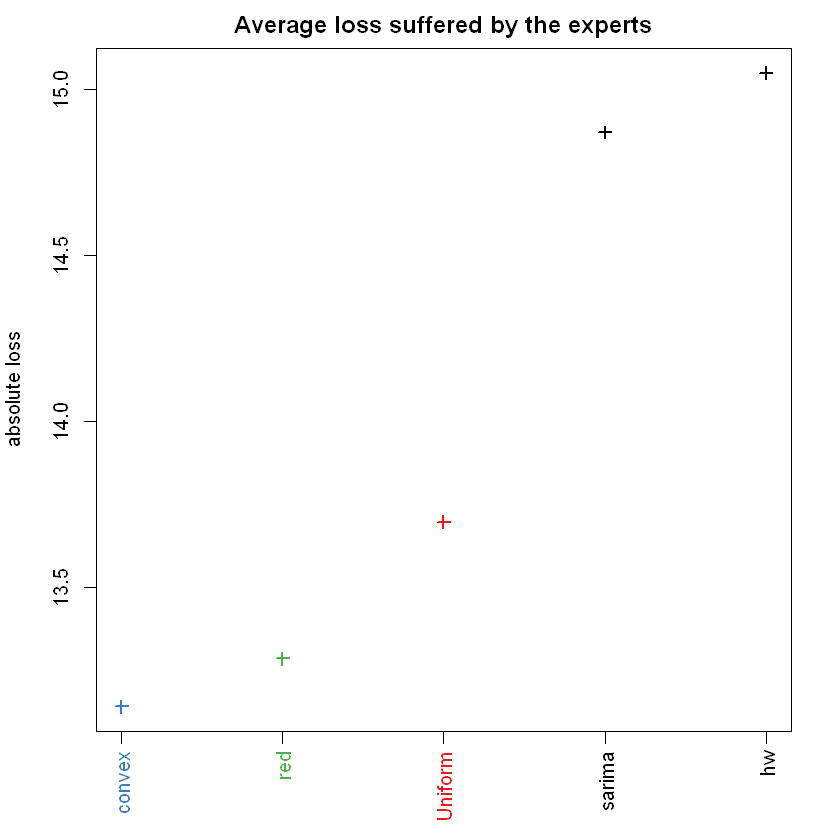

In [31]:
oracle.convex <- oracle(Y = acc.test, experts = X, loss.type = "absolute", model = "convex")
plot(oracle.convex)

#### Figura 36

Warning message in bestLinear(Y, experts, lambda = lambda, loss.type = loss.type):
"The best linear oracle is only approximated (using optim)."

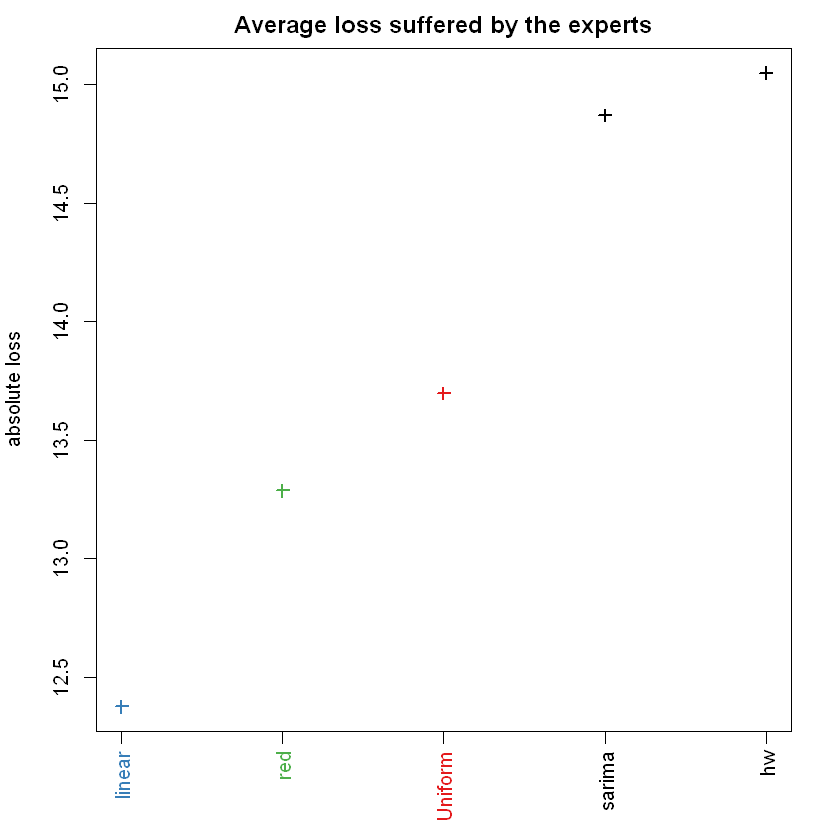

In [32]:
oracle.linear <- oracle(Y = acc.test, experts = X, loss.type = "absolute", model = "linear")
plot(oracle.linear)

####  Figura 37

Warning message in bestConvex(Y, experts, awake = awake, loss.type = loss.type, :
"The best convex oracle is only approximated (using optim)."Warning message in bestLinear(Y, experts, lambda = lambda, loss.type = loss.type):
"The best linear oracle is only approximated (using optim)."

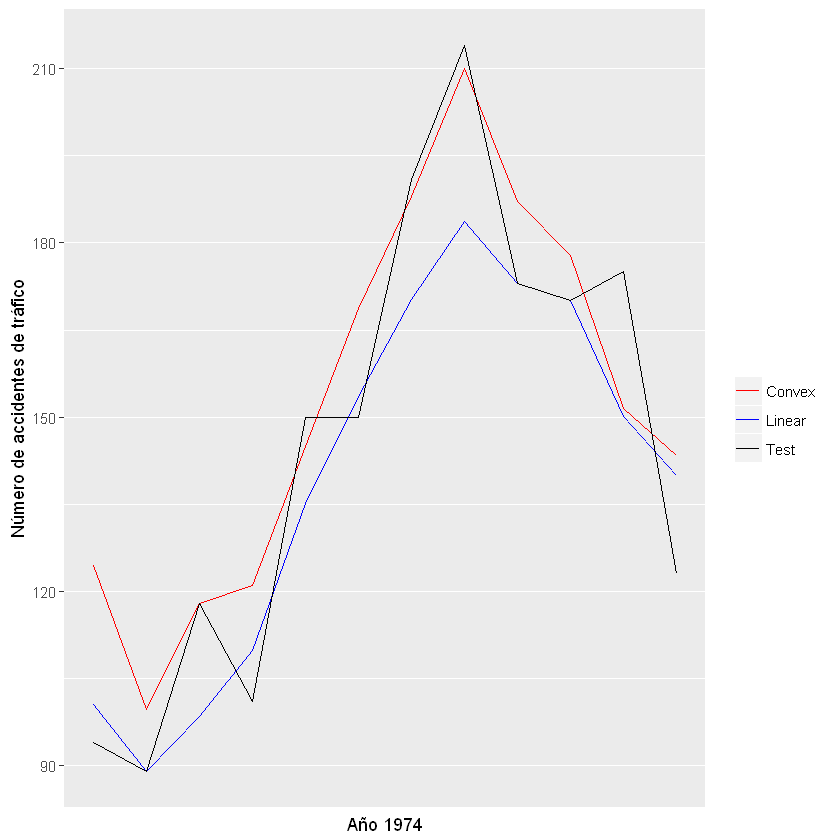

In [33]:
oracle.convex <- oracle(Y = acc.test, experts = X, loss.type = "absolute", model = "convex")
oracle.linear <- oracle(Y = acc.test, experts = X, loss.type = "absolute", model = "linear")
p <- ggplot() +
  geom_line(aes(x = index(acc.test),
                y = coredata(as.zoo(oracle.convex$prediction)), colour = 'Convex')) +
  geom_line(aes(x = index(acc.test),
                y = coredata(as.zoo(oracle.linear$prediction)), colour = 'Linear')) +
  geom_line(aes(x = index(as.zoo(acc.test)), y = coredata(acc.test), colour = 'Test')) +
  scale_color_manual(name = '', values = c('Test' = 'black', 'Convex' = 'red', 'Linear' = 'blue'),
                     labels = c('Convex','Linear', 'Test')) +
  xlab('Año 1974') + ylab('Número de accidentes de tráfico') +
  scale_x_continuous(breaks = c(), labels = c())
p

#### Figura 38

Aggregation rule: EWA 
Loss function:  absolute loss 
Gradient trick:  TRUE 
Coefficients: 
 red   sarima       hw
   1 1.51e-05 4.84e-11


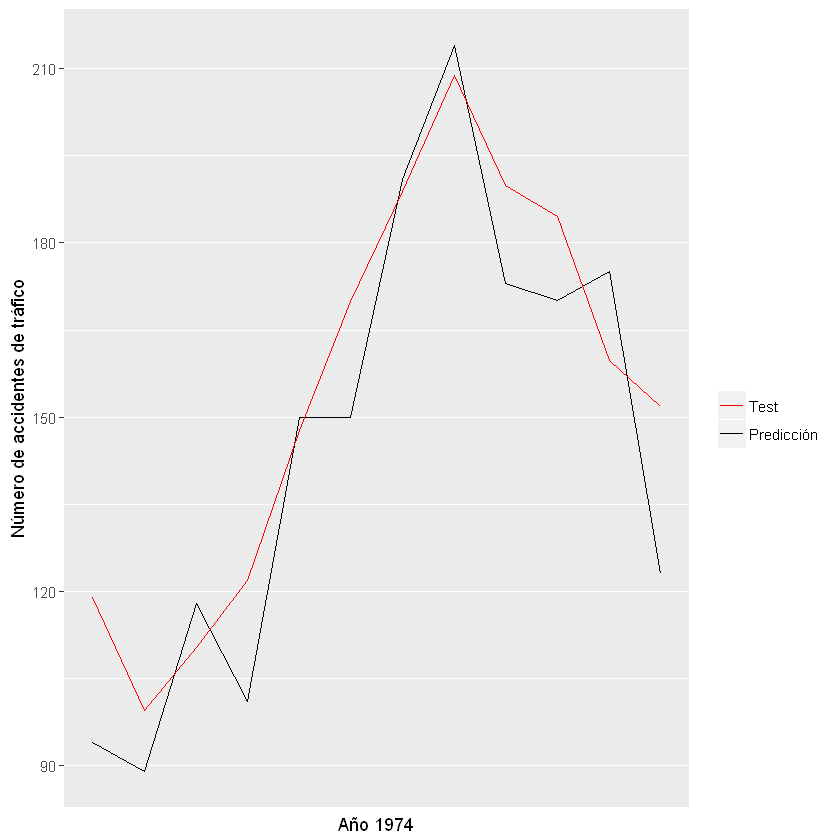

In [34]:
mix <- mixture(model = 'EWA', loss.type = 'absolute', coefficients = 'Uniform')
model <- mix
for (i in 1:length(as.vector(acc.test))) {
  model <- predict(model, X[i,], as.vector(acc.test)[i])
}
print(model)
combine(acc.test, model$prediction)

#### Figura 39

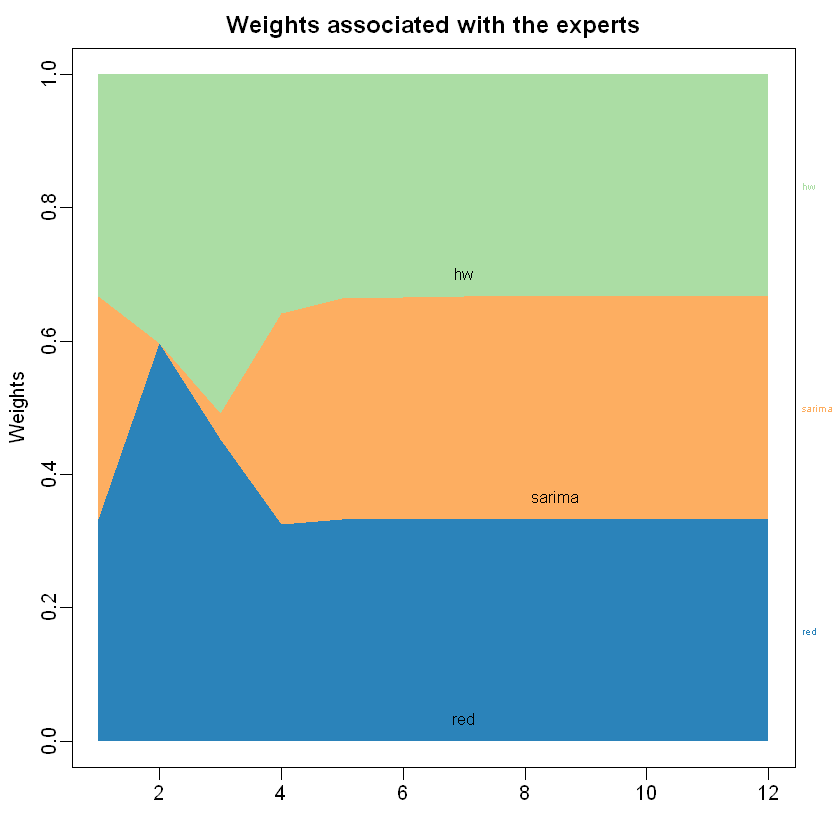

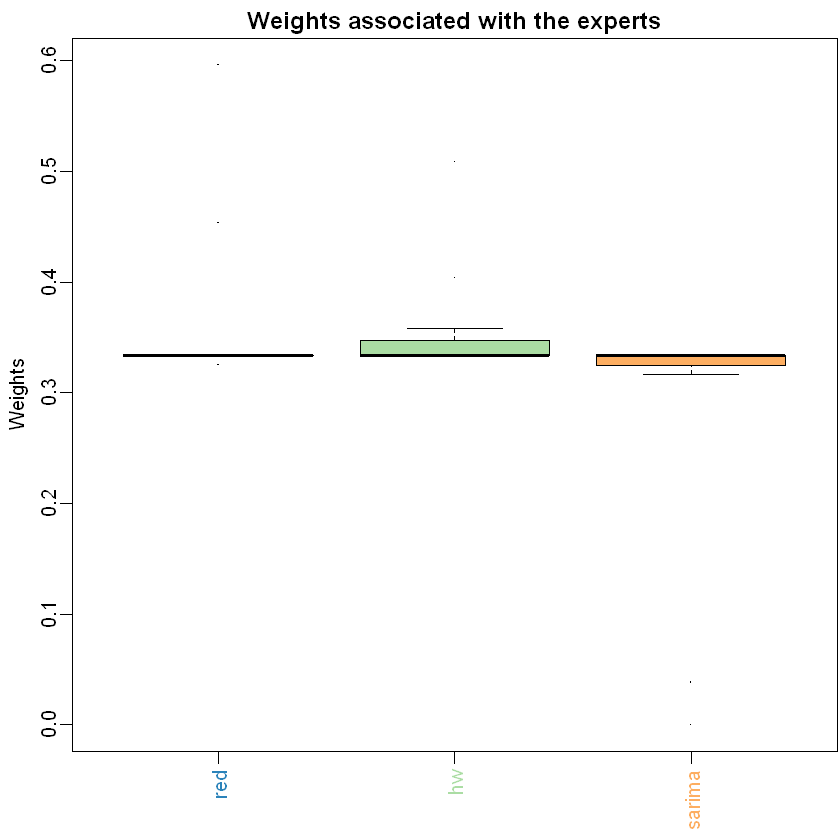

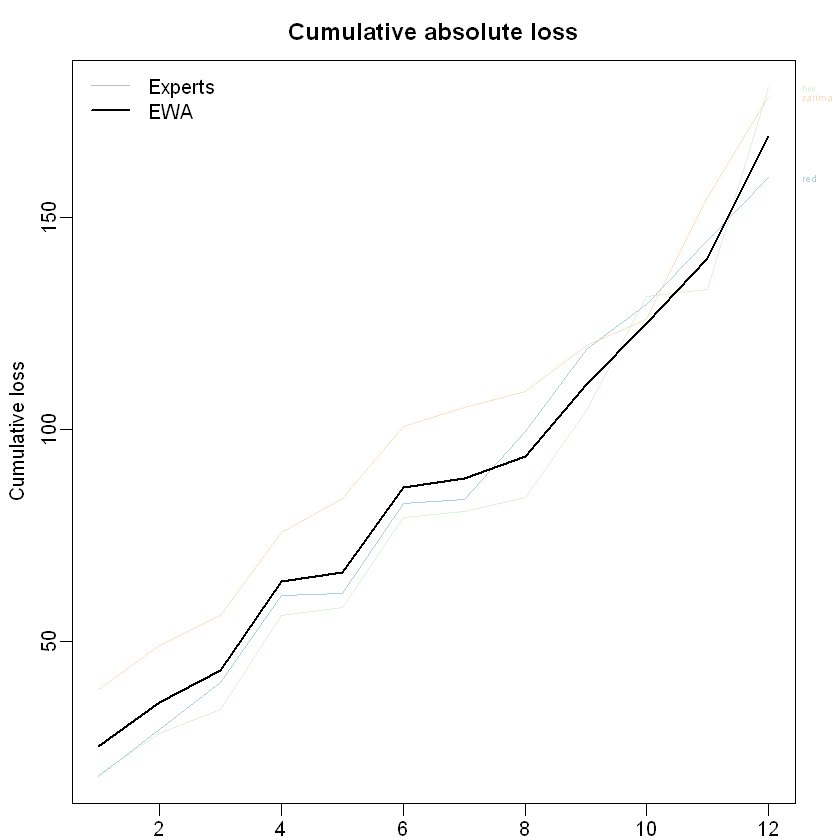

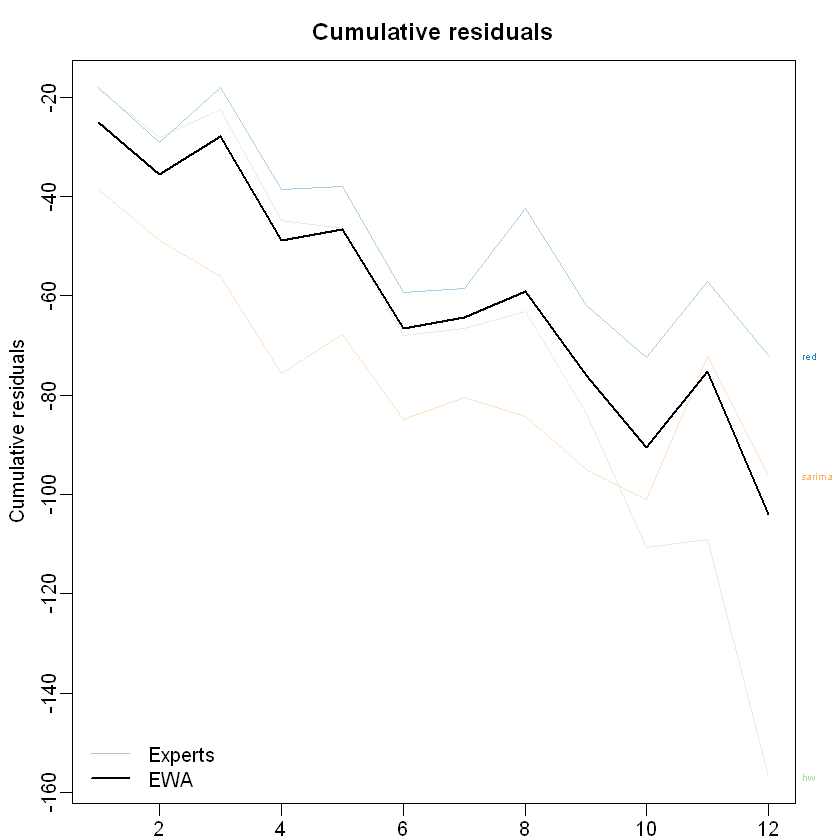

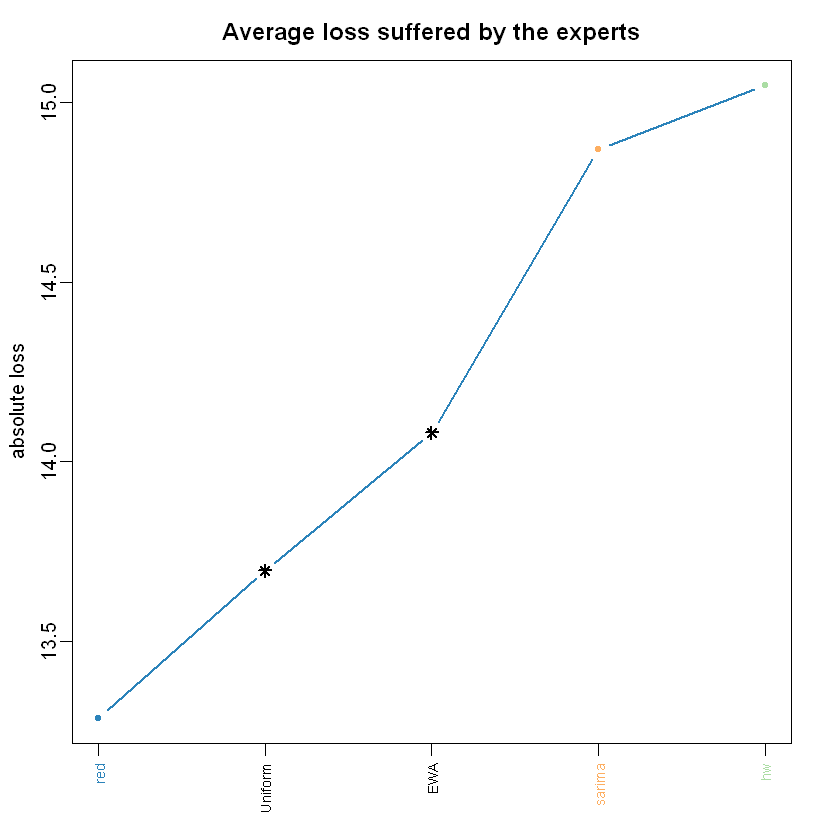

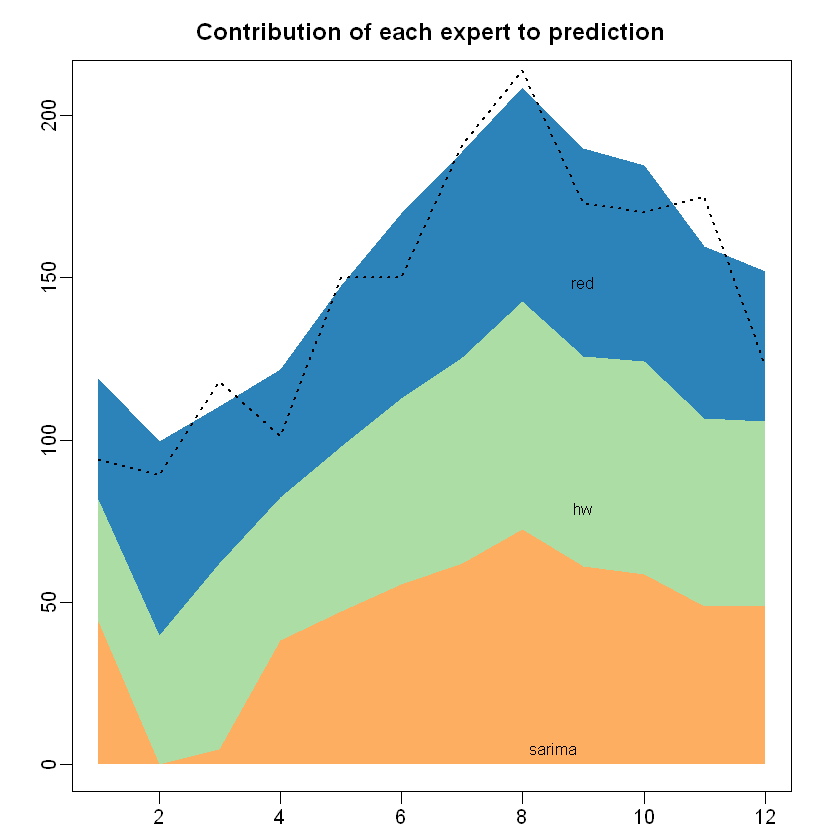

In [35]:
plot(model, pause = TRUE)